<a href="https://colab.research.google.com/github/sofijad996/AVSP_20194002/blob/main/NLP_Disaster_Tweets_AVSP_20194002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sample_submission.csv to sample_submission (6).csv
Saving test.csv to test (6).csv
Saving train.csv to train (6).csv


In [ ]:
import io
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)
import re, string
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import StratifiedShuffleSplit
from collections import  Counter
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,f1_score


train = pd.read_csv(io.BytesIO(uploaded['train.csv']))
test = pd.read_csv(io.BytesIO(uploaded['test.csv']))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Exploratory Data Analysis (EDA)

Performing Exploratory Data Analysis to gain insight about the dataset, useful for further data pre-processing, feature engineering and hyper-parameter optimization.


In [ ]:
train.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [ ]:
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1


In [ ]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
train['length']=train['text'].str.len()
train['number_of_words']=train['text'].str.split().map(lambda x: len(x))

In [ ]:
train.head()

,id,keyword,location,text,target,length,number_of_words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,133,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,65,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88,16


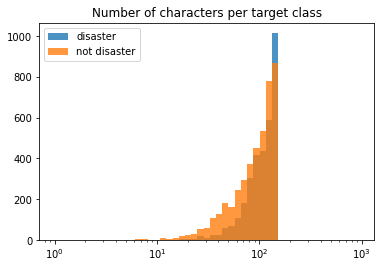

In [ ]:
plt.xscale('log')
bins = 1.15**(np.arange(0,50))
plt.hist(train[train['target']==1]['length'],bins=bins,alpha=0.8)
plt.hist(train[train['target']==0]['length'],bins=bins,alpha=0.8)
plt.title('Number of characters per target class')
plt.legend(('disaster','not disaster'))
plt.show()

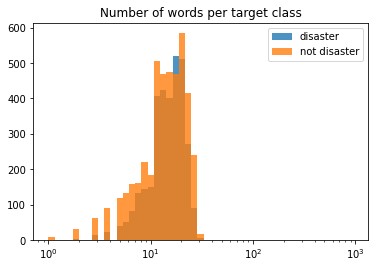

In [ ]:
plt.xscale('log')
bins = 1.15**(np.arange(0,50))
plt.hist(train[train['target']==1]['number_of_words'],bins=bins,alpha=0.8)
plt.hist(train[train['target']==0]['number_of_words'],bins=bins,alpha=0.8)
plt.title('Number of words per target class')
plt.legend(('disaster','not disaster'))
plt.show()

In [ ]:
train.describe(include='all')

,id,keyword,location,text,target,length,number_of_words
count,7613.000000,7552,5080,7613,7613.00000,7613.000000,7613.000000
unique,NaN,221,3341,7503,NaN,NaN,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,NaN,NaN,NaN
freq,NaN,45,104,10,NaN,NaN,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966,101.037436,14.903586
std,3137.116090,NaN,NaN,NaN,0.49506,33.781325,5.732604
min,1.000000,NaN,NaN,NaN,0.00000,7.000000,1.000000
25%,2734.000000,NaN,NaN,NaN,0.00000,78.000000,11.000000
50%,5408.000000,NaN,NaN,NaN,0.00000,107.000000,15.000000
75%,8146.000000,NaN,NaN,NaN,1.00000,133.000000,19.000000


In [ ]:
keywords = train['keyword'].unique()
keywords

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [ ]:
locations = train['location'].unique()
locations.size

3342

In [ ]:
train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

In [ ]:
locations = train['location'].unique()
locations.size

3313

## Data Pre-Processing

*   Extracting stop words from the corpus to remove words common in English langiuage, that don't hold relevant information and create additional noise.
*   Using RegEx to clean text in square brackets, remove links, remove punctuation and words containing numbers.
*   Removing emoji characters.
*   Removing special Unicode characters.
*   For duplicated tweets which have incorrectly labeled target classes (the same tweet being classified in both classes for different instances), the target class with most frequency is assigned to all instances of the tweet.
*   Creating a function for further Tokenization & Lemmatization of the text for the Pipeline.






In [ ]:
stop_words=set(stopwords.words('english'))

In [ ]:
disaster_corpus=[]
for x in train[train['target']==1]['text'].str.split():
    for i in x:
        if(i not in stop_words): disaster_corpus.append(i)

ndisaster_corpus=[]
for x in train[train['target']==0]['text'].str.split():
    for i in x:
        if(i not in stop_words): ndisaster_corpus.append(i)

In [ ]:
disaster_common_words = Counter(disaster_corpus).most_common()
disaster_common_words[:20]

[('-', 389),
 ('I', 259),
 ('The', 257),
 ('A', 167),
 ('via', 115),
 ('fire', 108),
 ('...', 106),
 ('&amp;', 105),
 ('In', 90),
 ('California', 86),
 ('killed', 86),
 ('like', 85),
 ('people', 83),
 ('suicide', 71),
 ('2', 67),
 ('More', 66),
 ('This', 61),
 ('Hiroshima', 59),
 ('disaster', 59),
 ('Northern', 58)]

In [ ]:
ndisaster_common_words = Counter(ndisaster_corpus).most_common()
ndisaster_common_words[:20]

[('I', 938),
 ('-', 374),
 ('The', 295),
 ('like', 233),
 ('&amp;', 190),
 ("I'm", 185),
 ('??', 183),
 ('get', 142),
 ('A', 123),
 ('via', 93),
 ('|', 91),
 ('one', 89),
 ('new', 86),
 ('would', 84),
 ('You', 79),
 ('My', 78),
 ('2', 78),
 ('got', 75),
 ('????', 74),
 ('know', 71)]

In [ ]:
train['text'].head()

0                                                                    Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1                                                                                                   Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3                                                                        13,000 people receive #wildfires evacuation orders in California 
4                                                 Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
Name: text, dtype: object

In [ ]:
def clean_text(text):
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

train['text'] = train['text'].apply(lambda x: clean_text(x))
train['text'].head(10)

0                                                                  Our Deeds are the Reason of this earthquake May ALLAH Forgive us all
1                                                                                                 Forest fire near La Ronge Sask Canada
2    All residents asked to shelter in place are being notified by officers No other evacuation or shelter in place orders are expected
3                                                                             people receive wildfires evacuation orders in California 
4                                                Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school 
5                                 RockyFire Update  California Hwy  closed in both directions due to Lake County fire  CAfire wildfires
6                                          flood disaster Heavy rain causes flash flooding of streets in Manitou Colorado Springs areas
7                                               

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
train['text']=train['text'].apply(lambda x: remove_emoji(x))

In [ ]:
train.head(10)

,id,keyword,location,text,target,length,number_of_words
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake May ALLAH Forgive us all,1,69,13
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1,38,7
2,5,NaN,NaN,All residents asked to shelter in place are being notified by officers No other evacuation or shelter in place orders are expected,1,133,22
3,6,NaN,NaN,people receive wildfires evacuation orders in California,1,65,8
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school,1,88,16
5,8,NaN,NaN,RockyFire Update California Hwy closed in both directions due to Lake County fire CAfire wildfires,1,110,18
6,10,NaN,NaN,flood disaster Heavy rain causes flash flooding of streets in Manitou Colorado Springs areas,1,95,14
7,13,NaN,NaN,Im on top of the hill and I can see a fire in the woods,1,59,15
8,14,NaN,NaN,Theres an emergency evacuation happening now in the building across the street,1,79,12
9,15,NaN,NaN,Im afraid that the tornado is coming to our area,1,52,10


In [ ]:
train['text'][178:185]

178       AMBULANCE SPRINTER AUTOMATIC FRONTLINE VEHICLE CHOICE OF  LEZ COMPLIANT  eBay 
179                  New Nanotech Device Will Be Able To Target And Destroy Blood Clots 
180                      it was hella crazy  fights an ambulance and a couple mosh pits 
181                If I get run over by an ambulance am I lucky justsaying randomthought
182    news Twelve feared killed in Pakistani air ambulance helicopter crash  tilnow DNA
183                    Twelve feared killed in Pakistani air ambulance helicopter crash 
184                                                    TanSlash waiting for an ambulance
Name: text, dtype: object

In [ ]:
def display_problematic_lines():
    return train.loc[(train['id'] == 6) |
                     (train['id'] == 54) |
                     (train['id'] == 5937) |
                     (train['id'] == 5876) |
                     (train['id'] == 10113)
                    ]['text']

display_problematic_lines()

3                                                                    people receive wildfires evacuation orders in California 
36      PhDSquares mufc theyve built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season
4133                The Stephen Ave flower pots got a little ripped up in the hailstorm today yyc abstorm calgary iamdowntown 
4180                                                     Lifestyle Û÷It makes me sickÛª Baby clothes deemed a Û÷hazardÛª  
7059                                                              A look at state actions a year after FergusonÛªs upheaval  
Name: text, dtype: object

In [ ]:
def clean_problematic_text(text):
    text = re.sub('Û÷', '', text)
    text = re.sub('Ûª', '', text)
    return text

train['text'] = train['text'].apply(lambda x: clean_problematic_text(x))
display_problematic_lines()

3                                                                    people receive wildfires evacuation orders in California 
36      PhDSquares mufc theyve built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season
4133                The Stephen Ave flower pots got a little ripped up in the hailstorm today yyc abstorm calgary iamdowntown 
4180                                                                 Lifestyle It makes me sick Baby clothes deemed a hazard  
7059                                                                 A look at state actions a year after Fergusons upheaval  
Name: text, dtype: object

In [ ]:
def check_for_duplicates_with_different_targets(df, col1, col2):
  grouped = df.groupby(col1)[col2].nunique()
  result = grouped[grouped > 1].index.tolist()
  return len(result)

check_for_duplicates_with_different_targets(train, 'text', 'target')

76

In [ ]:
def add_avg_target_column(df, col1, col2):
    df['avg_target'] = df.groupby(col1)[col2].transform('mean')
    return df

train = add_avg_target_column(train, 'text', 'target')
train['target'] = train['avg_target'].round().astype('int64')

In [ ]:
check_for_duplicates_with_different_targets(train, 'text', 'target')

0

In [ ]:
train.head(10)

,id,keyword,location,text,target,length,number_of_words,avg_target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake May ALLAH Forgive us all,1,69,13,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1,38,7,1.0
2,5,NaN,NaN,All residents asked to shelter in place are being notified by officers No other evacuation or shelter in place orders are expected,1,133,22,1.0
3,6,NaN,NaN,people receive wildfires evacuation orders in California,1,65,8,1.0
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school,1,88,16,1.0
5,8,NaN,NaN,RockyFire Update California Hwy closed in both directions due to Lake County fire CAfire wildfires,1,110,18,1.0
6,10,NaN,NaN,flood disaster Heavy rain causes flash flooding of streets in Manitou Colorado Springs areas,1,95,14,1.0
7,13,NaN,NaN,Im on top of the hill and I can see a fire in the woods,1,59,15,1.0
8,14,NaN,NaN,Theres an emergency evacuation happening now in the building across the street,1,79,12,1.0
9,15,NaN,NaN,Im afraid that the tornado is coming to our area,1,52,10,1.0


In [ ]:
def preprocess(text): 
    word_tokens = word_tokenize(text) 
    filtered_text = [word for word in word_tokens if word not in stop_words] 
    final_text=[WordNetLemmatizer().lemmatize(word,pos ='v') for word in filtered_text]
    return final_text 

## Hyper-parameter tuning with GridSearchCV

In [ ]:
X=train['text']
y=train['target']
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X, y, test_size=0.2)

vect = CountVectorizer()
X_train_vectorized = vect.fit_transform(X_train_cv)
X_test_vectorized = vect.transform(X_test_cv)

tfidf = TfidfTransformer()
X_train_transformed = tfidf.fit_transform(X_train_vectorized)
X_test_transformed = tfidf.fit_transform(X_test_vectorized)

In [ ]:
def print_grid_search_cv_results(grid_search):
  print('Best score: ', grid_search.best_score_)
  print('Parameters that provide best results: ', grid_search.best_params_)
  print('Estimator chosen by the search: ', grid_search.best_estimator_)

In [ ]:
parameters_SVC = [{'C':[1, 2, 3], 'kernel':['linear']}]
grid_search_SVC = GridSearchCV(estimator=SVC(), param_grid=parameters_SVC, scoring='f1', cv=5, verbose=0)

grid_search_SVC.fit(X_train_transformed, y_train_cv)
print_grid_search_cv_results(grid_search_SVC)

Best score:  0.7575098353001283
Parameters that provide best results:  {'C': 1, 'kernel': 'linear'}
Estimator chosen by the search:  SVC(C=1, kernel='linear')


In [ ]:
parameters_SVC_rbf = [{'C':[1, 2, 3], 'kernel':['rbf']}]
grid_search_SVC_rbf = GridSearchCV(estimator=SVC(), param_grid=parameters_SVC_rbf, scoring='f1', cv=5, verbose=0)

grid_search_SVC_rbf.fit(X_train_transformed, y_train_cv)
print_grid_search_cv_results(grid_search_SVC_rbf)

Best score:  0.751896250045544
Parameters that provide best results:  {'C': 3, 'kernel': 'rbf'}
Estimator chosen by the search:  SVC(C=3)


In [ ]:
parameters_NB = [{'alpha':[1.0, 1.5, 2.0]}]
grid_search_NB = GridSearchCV(estimator=MultinomialNB(), param_grid=parameters_NB, scoring='f1', cv=5, verbose=0)

grid_search_NB.fit(X_train_transformed, y_train_cv)
print_grid_search_cv_results(grid_search_NB)

Best score:  0.7298060807926399
Parameters that provide best results:  {'alpha': 1.0}
Estimator chosen by the search:  MultinomialNB()


In [ ]:
parameters_KNN = [{'metric':['minkowski', 'euclidean', 'manhattan'], 'n_neighbors':[4, 5, 6]}]
grid_search_KNN = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=parameters_KNN, scoring='f1', cv=5, verbose=0)

grid_search_KNN.fit(X_train_transformed, y_train_cv)
print_grid_search_cv_results(grid_search_KNN)

Best score:  0.6979558778217748
Parameters that provide best results:  {'metric': 'minkowski', 'n_neighbors': 5}
Estimator chosen by the search:  KNeighborsClassifier()


## Model Building & Testing

In [ ]:
def build_pipeline(clf):
    pipeline=Pipeline([
      ('bow', CountVectorizer(analyzer=preprocess)),  
      ('tfidf', TfidfTransformer()), 
      ('classifier', clf),  
    ])
    return pipeline

def show_metrics(y_test, predictions):
    print("Metrics Report: \n", classification_report(predictions, y_test))
    print("Confusion Matrix: \n ", confusion_matrix(predictions, y_test))
    print("Accuracy Score:", round(accuracy_score(predictions, y_test), 2))
    print("f1 Score:", round(f1_score(predictions, y_test), 2))
    
def train_model(x_train, y_train, model):
        pipeline=build_pipeline(model)
        trained_pipeline=pipeline.fit(x_train, y_train)
        return trained_pipeline
       
def predict(y_test, trained_pipeline):
    predictions=trained_pipeline.predict(y_test)
    return predictions 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
models_to_train = {'Multinomial Naive Bayes': MultinomialNB(),
                 'K-Nearest Neighbors': KNeighborsClassifier(), 'Logistic Regression': LogisticRegression(), 
                 'SVM_rbf': SVC(C=2), 'SVM_linear':SVC(C=1, kernel='linear')}
predictions_dict = {}
f1_scores = []
names = ['Multinomial Naive Bayes', 'K-Nearest Neighbors', 'Logistic Regression','SVM_rbf', 'SVM_linear']
for name,model in models_to_train.items():
    print(f'Training {name} in progress... \n')
    trained_pipe=train_model(X_train,y_train,model)
    predictions=predict(X_test,trained_pipe)
    predictions_dict[name]=predictions
    print(f'Metrics for {name}: \n')
    show_metrics(predictions,y_test)
    f1_scores.append(round(f1_score(predictions,y_test), 2))
    print('\n')
    print('****************************\n')

print("List of models with f1 scores: \n")
score_per_classifier=zip(names, f1_scores)
print(list(score_per_classifier))

Training Multinomial Naive Bayes in progress... 

Metrics for Multinomial Naive Bayes: 

Metrics Report: 
               precision    recall  f1-score   support

           0       0.78      0.93      0.85       877
           1       0.87      0.65      0.75       646

    accuracy                           0.81      1523
   macro avg       0.83      0.79      0.80      1523
weighted avg       0.82      0.81      0.81      1523

Confusion Matrix: 
  [[814  63]
 [225 421]]
Accuracy Score: 0.81
f1 Score: 0.75


****************************

Training K-Nearest Neighbors in progress... 

Metrics for K-Nearest Neighbors: 

Metrics Report: 
               precision    recall  f1-score   support

           0       0.75      0.93      0.83       877
           1       0.86      0.59      0.70       646

    accuracy                           0.78      1523
   macro avg       0.80      0.76      0.76      1523
weighted avg       0.80      0.78      0.77      1523

Confusion Matrix: 
  [[813  

In [ ]:
trained_pipe=train_model(X_train, y_train,SVC(C=1, kernel='linear'))
predictions=predict(X_test, trained_pipe)

In [ ]:
show_metrics(predictions, y_test)

Metrics Report: 
               precision    recall  f1-score   support

           0       0.81      0.90      0.85       877
           1       0.83      0.71      0.77       646

    accuracy                           0.82      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.82      0.82      0.82      1523

Confusion Matrix: 
  [[786  91]
 [186 460]]
Accuracy Score: 0.82
f1 Score: 0.77


In [ ]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
test['text'] = test['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: remove_emoji(x))
test['text'] = test['text'].apply(lambda x: clean_problematic_text(x))
train['text'].head(10)

0                                                                  Our Deeds are the Reason of this earthquake May ALLAH Forgive us all
1                                                                                                 Forest fire near La Ronge Sask Canada
2    All residents asked to shelter in place are being notified by officers No other evacuation or shelter in place orders are expected
3                                                                             people receive wildfires evacuation orders in California 
4                                                Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school 
5                                 RockyFire Update  California Hwy  closed in both directions due to Lake County fire  CAfire wildfires
6                                          flood disaster Heavy rain causes flash flooding of streets in Manitou Colorado Springs areas
7                                               

In [ ]:
predictions_submission=predict(test['text'], trained_pipe)

In [ ]:
submission = pd.DataFrame({
    'id': test['id'],
    'target': predictions_submission
})
submission.to_csv('submission.csv', index=False)

submission.dtypes
submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.350904
std,3146.427221,0.477326
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [ ]:
submission.dtypes

id        int64
target    int64
dtype: object

In [ ]:
sample_submission = pd.read_csv(io.BytesIO(uploaded['sample_submission.csv']))
sample_submission.dtypes
sample_submission.describe()

,id,target
count,3263.000000,3263.0
mean,5427.152927,0.0
std,3146.427221,0.0
min,0.000000,0.0
25%,2683.000000,0.0
50%,5500.000000,0.0
75%,8176.000000,0.0
max,10875.000000,0.0


In [ ]:
sample_submission.dtypes

id        int64
target    int64
dtype: object

## Kaggle submission
This submission got a score of 0.79.

<img src="https://i.imgur.com/xluyPoR.png" alt="Alternative text" />

## Resources
* Ian H. Witten, Elbe Frank, Mark A. Hall, Data Mining: Practical Machine Learning Tools and Techniques, 4th edition (Morgan Kaufman, 2016),
* Jake VanderPlas, Python Data Science Handbook codebase: https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/Index.ipynb#scrollTo=EVoDQ2MKljg4
* Scikit-learn Documentation: https://scikit-learn.org/stable/user_guide.html
* Pronalazenje skrivenog znanja course pages: https://rti.etf.bg.ac.rs/rti/ms1psz/#
* Kaggle resources and competition entries:
  * https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained#2.-EDA-%F0%9F%93%8A
  * https://www.kaggle.com/code/satishgunjal/introduction-to-nlp
  * https://www.kaggle.com/code/faressayah/natural-language-processing-nlp-for-beginners
  * https://www.kaggle.com/code/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm/notebook#EDA-and-Preprocessing 
  * https://www.kaggle.com/code/hankarmostafa/predicting-disaster-tweets-with-naive-bayes
  * https://www.kaggle.com/code/fmitchell259/disaster-tweets-naive-bayes-svm-rnn/notebook
  * https://www.kaggle.com/code/christianwittmann/nlp-with-disaster-tweets-january-2023#Summary-of-Learnings-/-Improvements 

